In [122]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt

# Read the data
with nc.Dataset('tb_sfc_precip_2017_1_4_7_10.nc') as f:
    tb=f.variables['tb'][:]
    sfc_precip=f.variables['sfc_precip'][:]
    a=np.nonzero(tb[:,0]==tb[:,0])
    

In [123]:
print(tb.shape)
a=np.nonzero(sfc_precip==0)
b=np.nonzero(sfc_precip>0)

tb_resampled=[]
sfc_precip_resampled=[]
for tb1, sfc_precip1 in zip(tb, sfc_precip):
    if sfc_precip1==0:
        r=np.random.random()
        if r>0.3:
            continue
    tb_resampled.append(tb1)
    sfc_precip_resampled.append(sfc_precip1)

tb_resampled=np.array(tb_resampled)
sfc_precip_resampled=np.array(sfc_precip_resampled)
a=np.nonzero(sfc_precip_resampled>0)
b=np.nonzero(sfc_precip_resampled==0)
print(len(a[0]), len(b[0]))

(9674262, 9)
517344 2747069


In [124]:
tb_resampled=np.array(tb_resampled)
sfc_precip_resampled=np.array(sfc_precip_resampled)
tb_mean=np.mean(tb_resampled, axis=0)
tb_std=np.std(tb_resampled, axis=0)
X=(tb_resampled-tb_mean)/tb_std
y_bin=np.zeros((len(sfc_precip_resampled), 2))
y_bin[sfc_precip_resampled>0, 1]=1
y_bin[sfc_precip_resampled==0, 0]=1
y_reg=np.log10(1+sfc_precip_resampled/0.1)

In [115]:
#define pytorch feedforward neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class PrecipModelClassifier(nn.Module):
    def __init__(self,ninp=15,nout=1,nhid1=32,nhid2=32):
        self.ninp=ninp
        self.nhid1=nhid1
        self.nhid2=nhid2
        self.nout=nout
        super(PrecipModelClassifier, self).__init__()
        self.fc1 = nn.Linear(self.ninp, self.nhid1)
        self.fc2 = nn.Linear(self.nhid1, self.nhid2)
        self.fc3 = nn.Linear(self.nhid2, self.nout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x))
        return x
    
class PrecipModelRegressor(nn.Module):
    def __init__(self,ninp=15,nout=1,nhid1=32,nhid2=32):
        self.ninp=ninp
        self.nhid1=nhid1
        self.nhid2=nhid2
        self.nout=nout
        super(PrecipModelRegressor, self).__init__()
        self.fc1 = nn.Linear(self.ninp, self.nhid1)
        #self.fc2 = nn.Linear(self.nhid1, self.nhid2)
        self.fc3 = nn.Linear(self.nhid1, self.nout)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
print(X.shape)



(2337341, 9)


In [126]:
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, y[:,np.newaxis], test_size=0.2, random_state=42)
nt2=X.shape[0]//2
X_train=X[:nt2]
y_train=y_bin[:nt2,:]
X_test=X[nt2:]
y_test=y_bin[nt2:,:]
y_train_reg=y_reg[:nt2,np.newaxis]
y_test_reg=y_reg[nt2:,np.newaxis]
# make torch dataset and dataloader

from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train[:],dtype=torch.float32), torch.tensor(y_train[:],dtype=torch.float32))
train_reg_dataset = TensorDataset(torch.tensor(X_train[:],dtype=torch.float32), torch.tensor(y_train_reg[:],dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test,dtype=torch.float32), torch.tensor(y_test,dtype=torch.float32))
test_reg_dataset = TensorDataset(torch.tensor(X_test,dtype=torch.float32), torch.tensor(y_test_reg,dtype=torch.float32))
train_reg_loader=DataLoader(train_reg_dataset, batch_size=64, shuffle=True)
import torch.optim as optim

In [101]:
# train model with Adam optimizer, device is mac gpu
# print available devices
#print(torch.cuda.is_available())
#train model
precip_model_classifier=PrecipModelClassifier(ninp=9,nout=2,nhid1=32,nhid2=32)
optimizer = optim.Adam(precip_model_classifier.parameters(), lr=0.001)
#precip_model=PrecipModel(ninp=9,nout=1,nhid1=32,nhid2=32)
criterion = nn.BCELoss()
train_losses = []
test_losses = []
n_epochs = 10
for epoch in range(n_epochs):
    train_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = precip_model_classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_loader))
  
    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_loader)}')


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_11068/1913493130.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


Epoch 1, Train Loss: 0.1515249502723472
Epoch 2, Train Loss: 0.13622692485360494
Epoch 3, Train Loss: 0.13326445944003615
Epoch 4, Train Loss: 0.13180134450263709
Epoch 5, Train Loss: 0.13050795588440398
Epoch 6, Train Loss: 0.129626155771198
Epoch 7, Train Loss: 0.12879860249702083
Epoch 8, Train Loss: 0.12813995279738738
Epoch 9, Train Loss: 0.1273660940128283
Epoch 10, Train Loss: 0.12659194578187297


In [127]:
precip_model_regresor=PrecipModelRegressor(ninp=9,nout=1,nhid1=32,nhid2=32)
optimizer = optim.Adam(precip_model_regresor.parameters(), lr=0.001)

criterion = nn.MSELoss()
train_losses = []
test_losses = []
n_epochs = 10
for epoch in range(n_epochs):
    train_loss = 0.0
    for i, data in enumerate(train_reg_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = precip_model_regresor(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_losses.append(train_loss/len(train_reg_loader))
  
    print(f'Epoch {epoch+1}, Train Loss: {train_loss/len(train_reg_loader)}')

Epoch 1, Train Loss: 0.04499910078587687
Epoch 2, Train Loss: 0.04085382252940067
Epoch 3, Train Loss: 0.03983276215054146
Epoch 4, Train Loss: 0.03943431866850955
Epoch 5, Train Loss: 0.039159139520294046
Epoch 6, Train Loss: 0.03893784624074528
Epoch 7, Train Loss: 0.0387491296935979
Epoch 8, Train Loss: 0.0385386227608753
Epoch 9, Train Loss: 0.03839953130843733
Epoch 10, Train Loss: 0.03829556502796721


[[1.         0.70577363]
 [0.70577363 1.        ]]


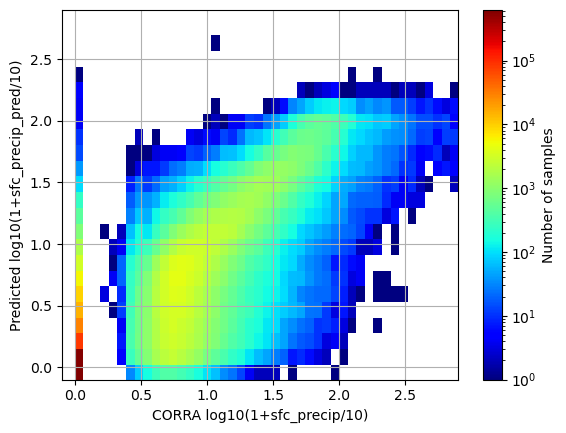

In [130]:
y_reg_pred=precip_model_regresor(torch.tensor(X_test,dtype=torch.float32)).detach().numpy()
a=np.nonzero(y_test_reg>0)
print(np.corrcoef(y_test_reg[a], y_reg_pred[a[0],0]))
h2d=plt.hist2d(y_test_reg[:,0], y_reg_pred[:,0], bins=50, cmap='jet',cmin=1,norm=LogNorm())
plt.xlabel('CORRA log10(1+sfc_precip/10)')
plt.ylabel('Predicted log10(1+sfc_precip_pred/10)')
plt.colorbar(h2d[3],label='Number of samples')
plt.xlim(-0.1,2.9)
plt.ylim(-0.1,2.9)
plt.grid()
plt.savefig('gmi_precip_regresor.png',dpi=300)



In [ ]:
scripted_regressor= torch.jit.script(precip_model_regresor)
scripted_regressor.save("precip_model_regresor.pt")
import pickle
with open('scaling_params.pklz', 'wb') as f:
    d_scaling={'mean':tb_mean, 'std':tb_std}
    pickle.dump(d_scaling, f)

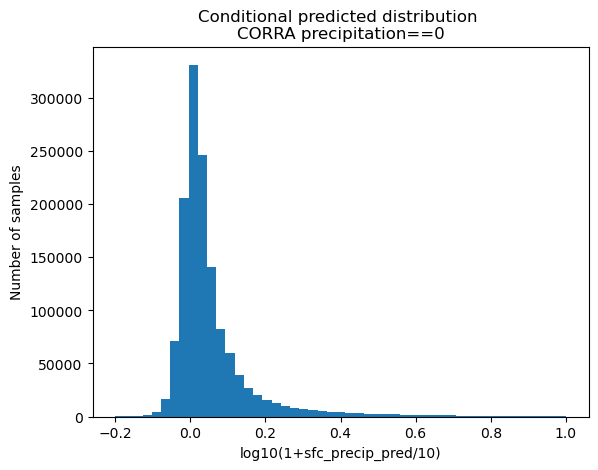

In [137]:
a_gmi=np.nonzero(y_test_reg[:,0]<0.001)
h1=plt.hist(y_reg_pred[a_gmi[0],0], bins=np.linspace(-0.2,1,50))
plt.xlabel('log10(1+sfc_precip_pred/10)')
plt.ylabel('Number of samples')
plt.title('Conditional predicted distribution \nCORRA precipitation==0')
plt.savefig('condDistri_precip_0.png',dpi=300)

In [106]:
y_pred=precip_model_classifier(torch.tensor(X_test,dtype=torch.float32)).detach().numpy()
# calculate accuracy
#calculate F1 score
from sklearn.metrics import accuracy_score, f1_score
print(np.corrcoef(y_pred[:,1],y_test[:,1]))
a1=np.nonzero((y_test[:,1]==1) & (y_pred[:,1]>0.5))
print(len(a1[0])/y_test[:,1].sum())

[[1.         0.83809442]
 [0.83809442 1.        ]]
0.7737986763012721


/var/folders/x_/d2_jzyq50052xh1_tk02bnmc0000gq/T/ipykernel_11068/1913493130.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc3(x))


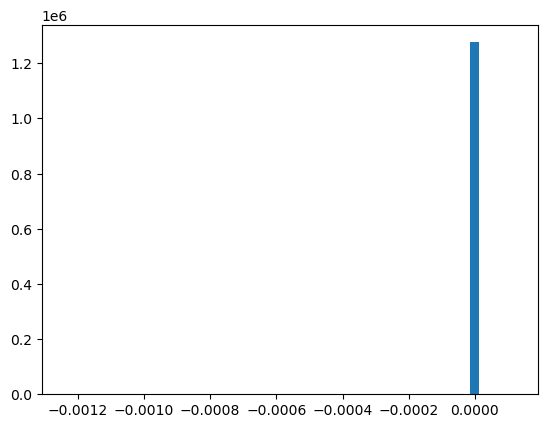

In [78]:
h1=plt.hist(y_pred[:,0],bins=50)